#### Lecture 13 - Uncertainty Analysis

##### Basics

Given a normally distributed sample of $n=30$ random variables with $\mu=0$ and $\sigma=1$. Compute the sample mean and standard deviation, and plot the histogram. Repeat with $n=1000$.

Example docs [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal). Then do the same thing with a uniform distribution, $a=0$ and $b=10$.

-0.03576059491170743
0.9759772434246125


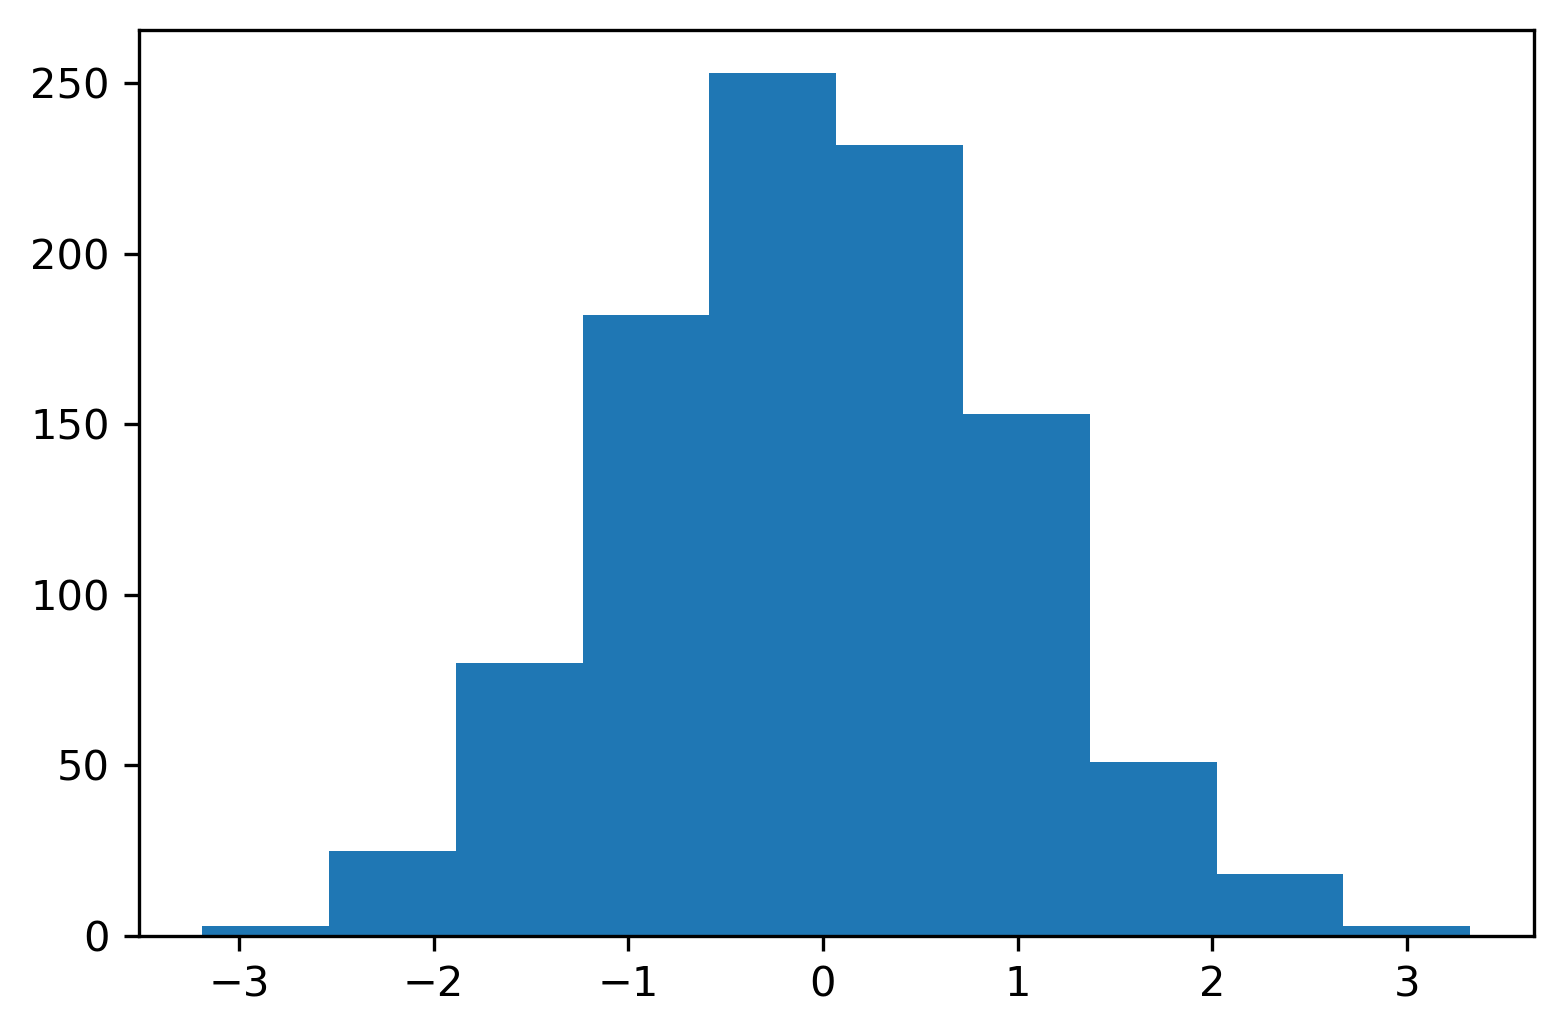

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

# leave out the random seed to get different values each run
rng = np.random.default_rng(seed=115)
data = rng.normal(0,1,1000)
print(data.mean())
print(data.std())
plt.hist(data)
plt.show()

4.976098595302498
2.7807162528387472


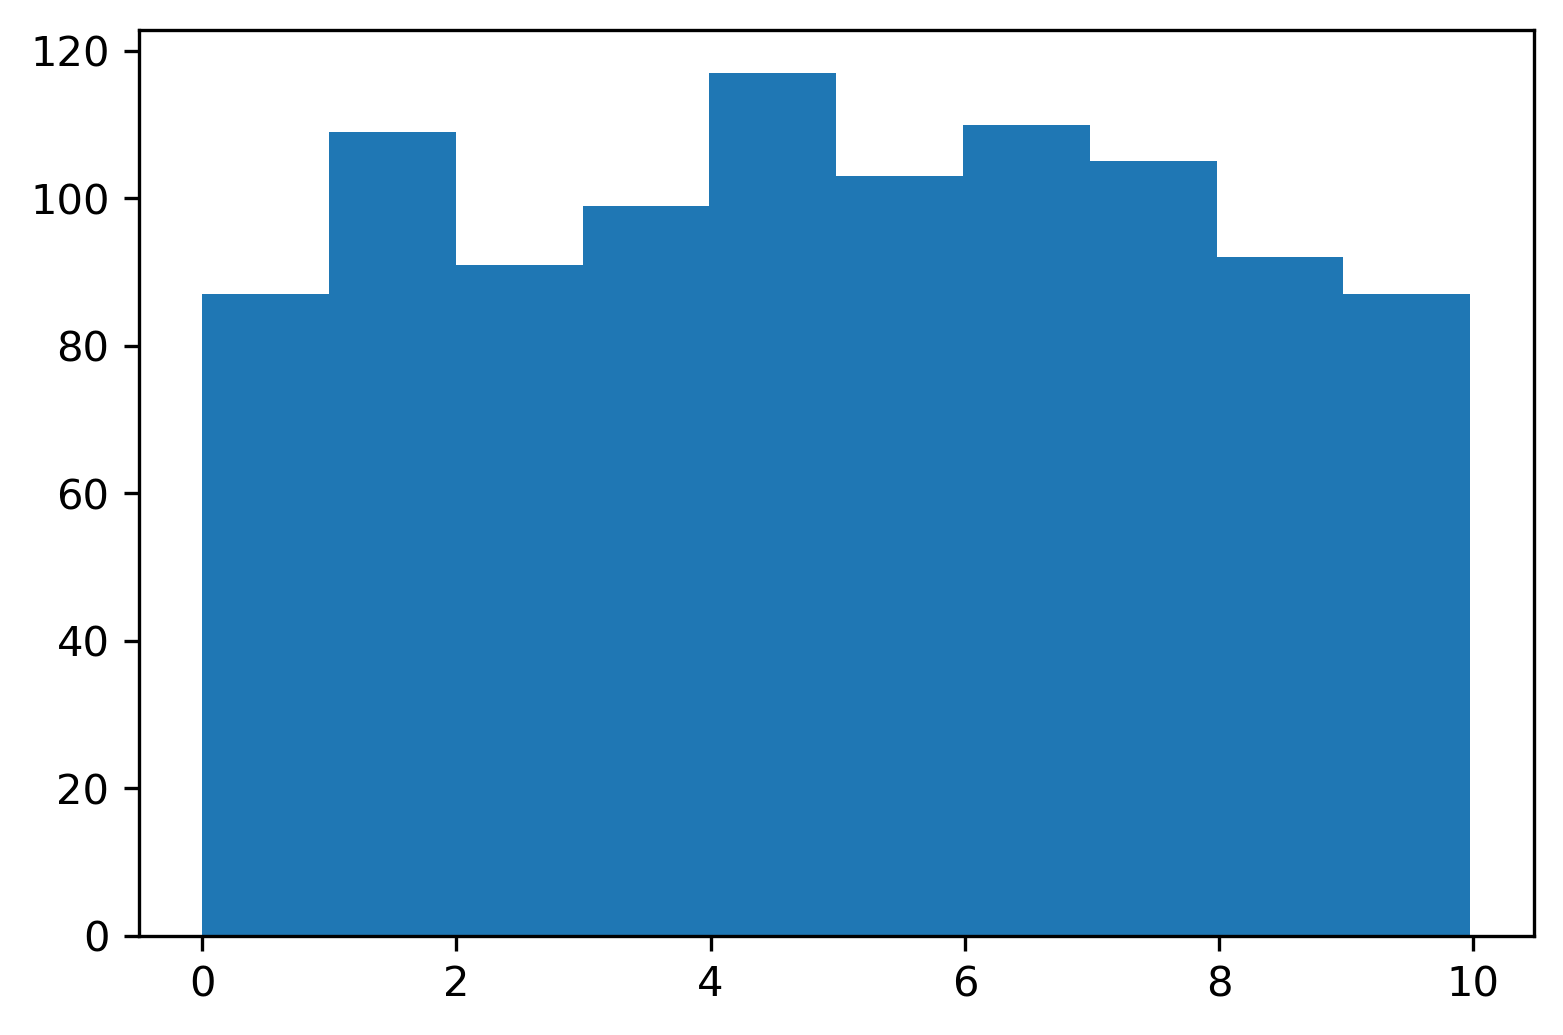

In [23]:
data = rng.uniform(0,10,1000)
print(data.mean())
print(data.std())
plt.hist(data)
plt.show()

##### Example 4.6 - Mast deflection Monte Carlo
Problem details in class slides.

y_mean =  0.16403925299643585
y_min =  0.15447505955309979
y_max =  0.1740732992392799


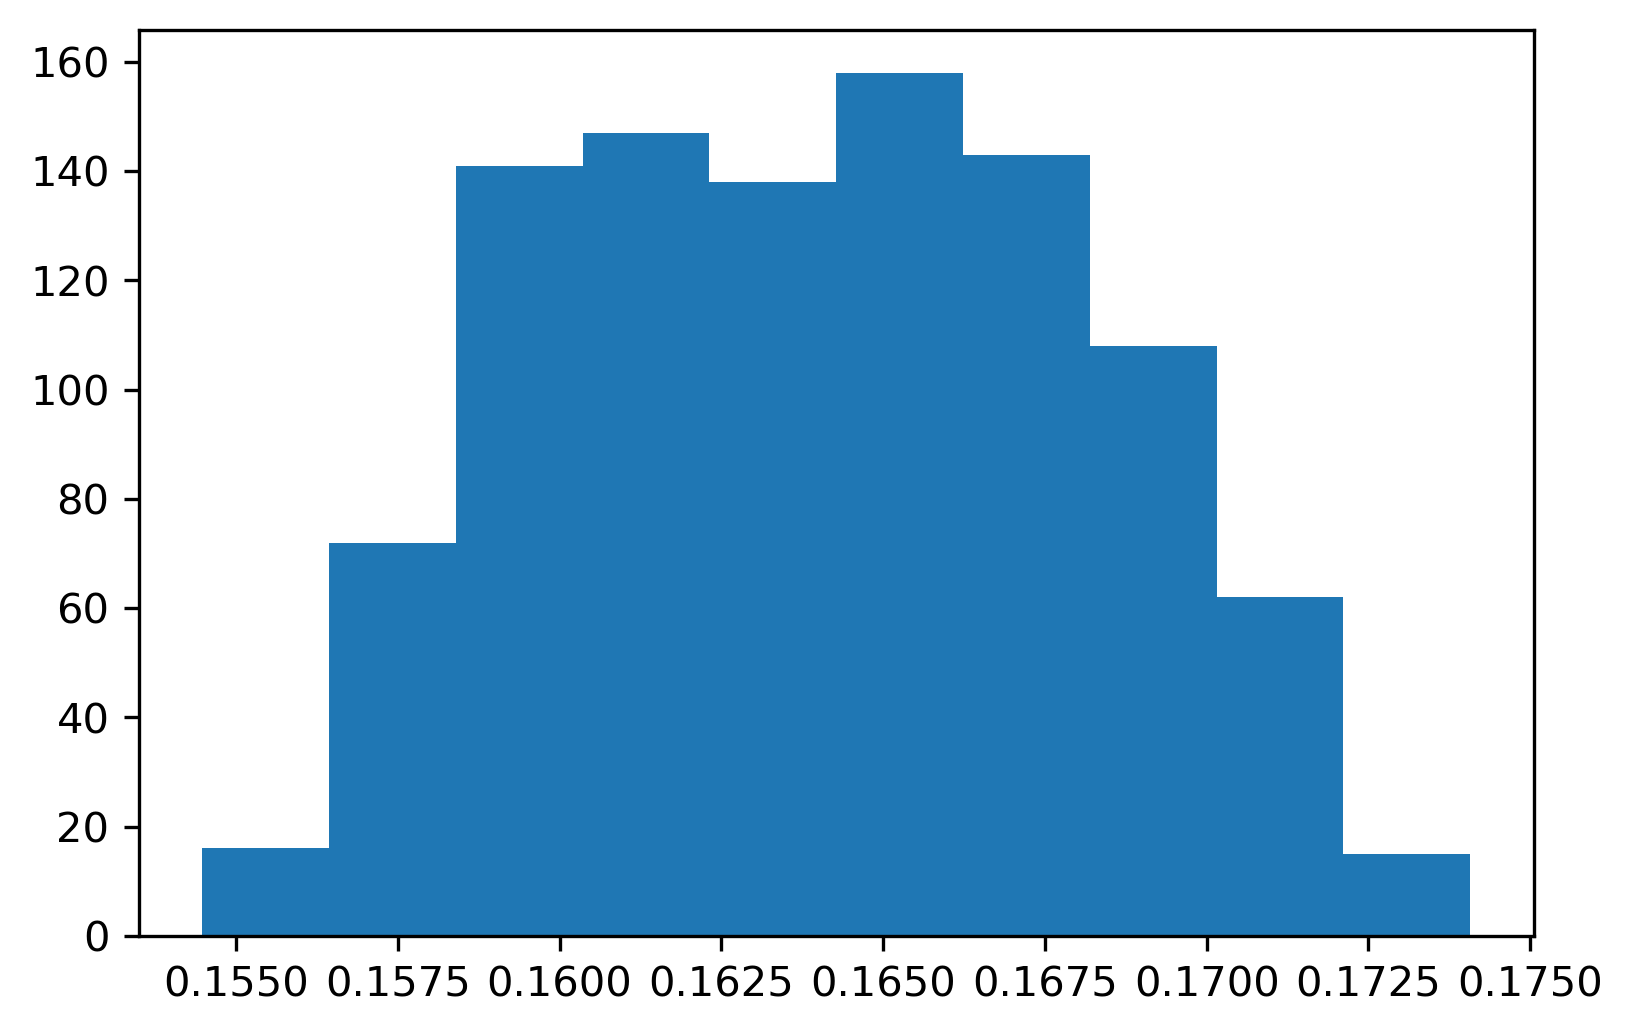

In [26]:
n = 1000
y = np.zeros(n)
F = rng.uniform(750-30, 750+30, n)
L = rng.uniform(9-0.03, 9+0.03, n)
E = rng.uniform(7.5e9-5e7, 7.5e9+5e7, n)
I = rng.uniform(5e-4-5e-6, 5e-4+5e-6, n)

for i in range(n):
    y[i] = F[i] * L[i]**4 / (8 * E[i] * I[i])

print('y_mean = ', y.mean())
print('y_min = ', y.min())
print('y_max = ', y.max())

plt.hist(y)
plt.show()

##### C&C Problem 4.16

First-order error propagation for Manning's equation in a rectangular channel.

Given: $Q=\frac{1}{n} \frac{(B H)^{5 / 3}}{(B+H)^{2 / 3}} \sqrt{S}$

Find $\Delta Q=\left|\frac{\partial Q}{\partial n}\right| \Delta \tilde{n}+\left|\frac{\partial Q}{\partial S}\right| \Delta \tilde{S}$

What is the contribution to the total error in the flowrate from errors in the roughness ($n$) and slope ($S$)? These values are measured to precision $\pm 10\%$.

Assume we can measure channel width ($B$) and height ($H$) exactly. The parameter values and ranges are given in the code.

In [34]:
B = 20 # width (m)
H = 0.3 # depth (m)
n = 0.03 # roughness (unitless)
S = 0.0003 # slope (unitless)
 
Q = (B*H)**(5/3) / (B+2*H)**(2/3) * (1/n) * S**(1/2)
 
# partial derivatives 
dQdn = -(B*H)**(5/3) / (B+2*H)**(2/3) * n**(-2) * S**(1/2)
dQds = (B*H)**(5/3) / (B+2*H)**(2/3) * 0.5*S**(-0.5) * (1/n)
 
dn = 0.10 * n # 10% uncertainty in n
ds = 0.10 * S # 10% uncertainty in S
dQ = np.abs(dQds)*ds + np.abs(dQdn)*dn # error in Q

print('Q = %0.2f +/- %0.2f m^3/s' % (Q, dQ))
print('n contributes %0.2f %%' % (np.abs(dQdn)*dn / dQ * 100))
print('S contributes %0.2f %%' % (np.abs(dQds)*ds / dQ * 100))

Q = 1.52 +/- 0.23 m^3/s
n contributes 66.67 %
S contributes 33.33 %


Repeat with Monte Carlo simulation, 1000 samples. Assume that $S$ and $n$ are uniformly distributed between $\pm 10\%$ of their estimated values.

Q_mean =  1.5243037231277703
Q_min =  1.3152869356747314
Q_max =  1.7668762944715863


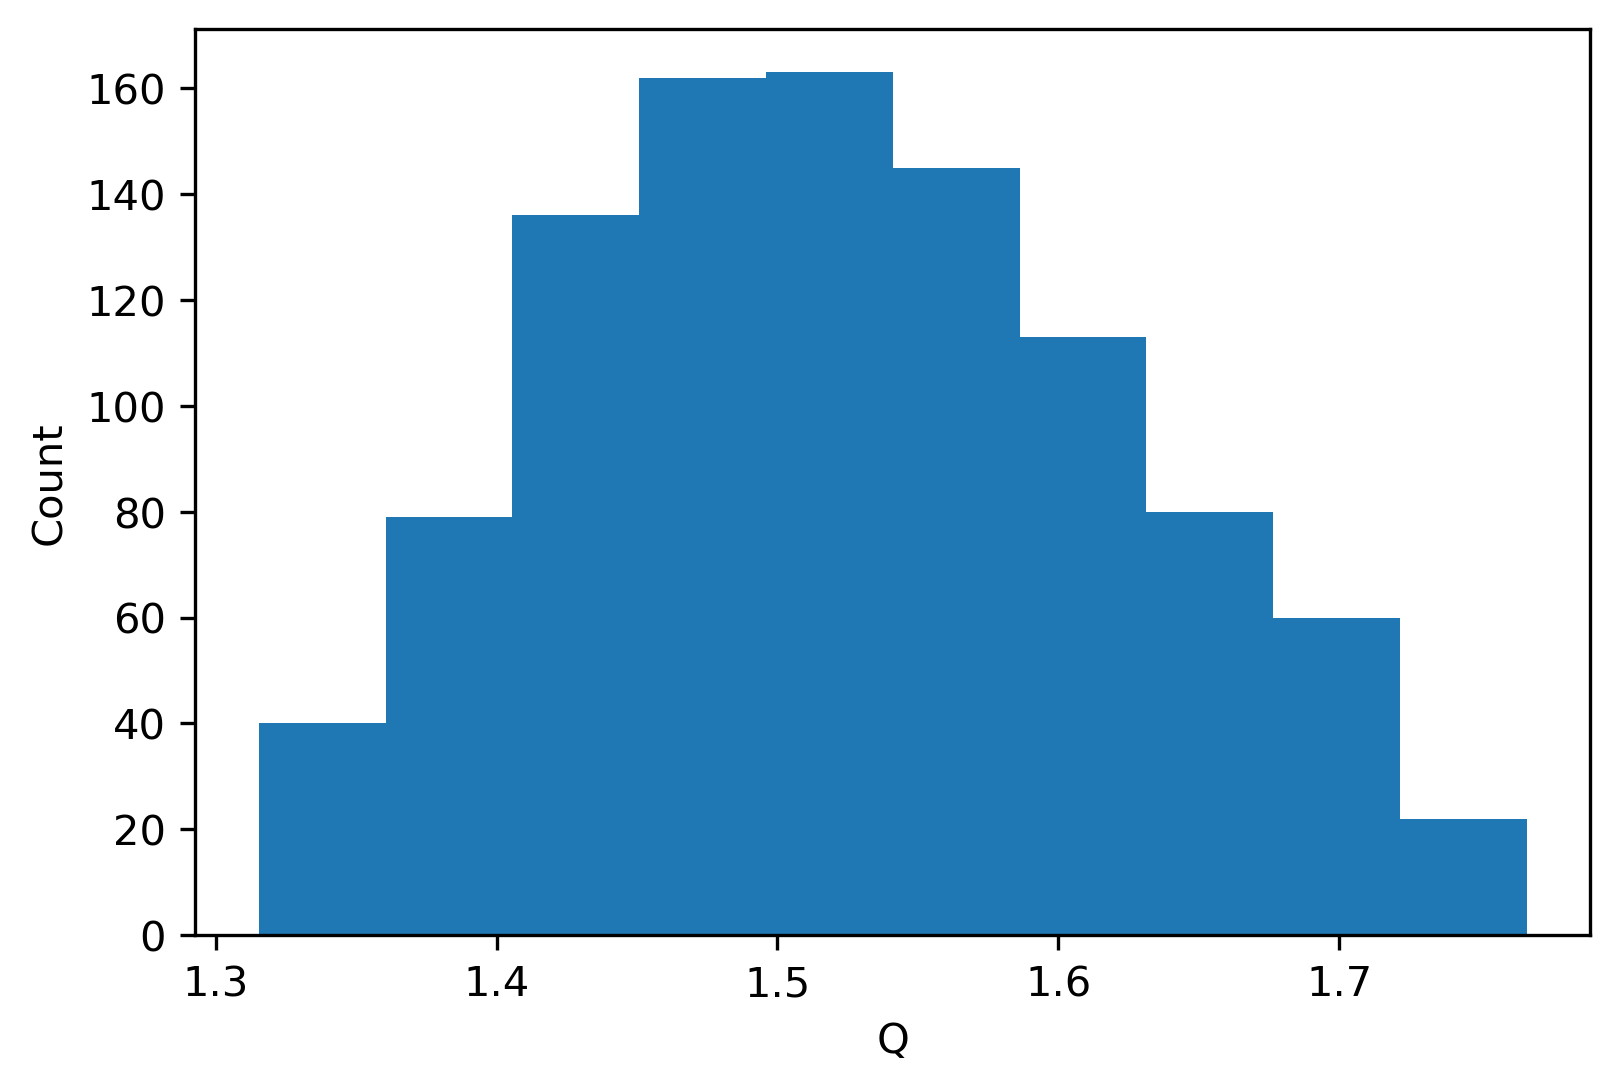

In [38]:
n_samples = 1000 # not to be confused with roughness n
Q_array = np.zeros(n_samples)
S_array = rng.uniform(0.9 * S, 1.1 * S, n_samples)
n_array = rng.uniform(0.9 * n, 1.1 * n, n_samples)

for i in range(n_samples):
    Q_array[i] = (B*H)**(5/3) / (B+2*H)**(2/3) * (1/n_array[i]) * S_array[i]**(1/2)

print('Q_mean = ', Q_array.mean())
print('Q_min = ', Q_array.min())
print('Q_max = ', Q_array.max())

plt.hist(Q_array)
plt.xlabel('Q')
plt.ylabel('Count')
plt.show()

Similar to the mast deflection example, the linear approximation works pretty well to estimate the range of min/max values. The Monte Carlo simulation tells us more about the distribution of outputs (assuming that the input parameters are uniformly distributed). This starts to look normally distributed and could be described as a confidence interval.

##### Logistic growth with harvesting - ODE

Given logistic growth model with harvesting (from L11):

$$ \frac{dP}{dt} = rP(1-\frac{P}{K}) - hP $$

- Harvesting rate $h=0.5$ is constant
- Growth rate $r$ is uniformly distributed on $[0.9,1.1]$
- Carrying capacity $K$ is uniformly distributed on $[9.0,11.0]$

Use Monte Carlo sampling with 100 samples. For each sample, solve the ODE using `scipy.integrate.solve_ivp` over $t \in [0,100]$. Then create:
- A timeseries plot of population for each parameter sample
- Histogram and confidence interval of steady state population

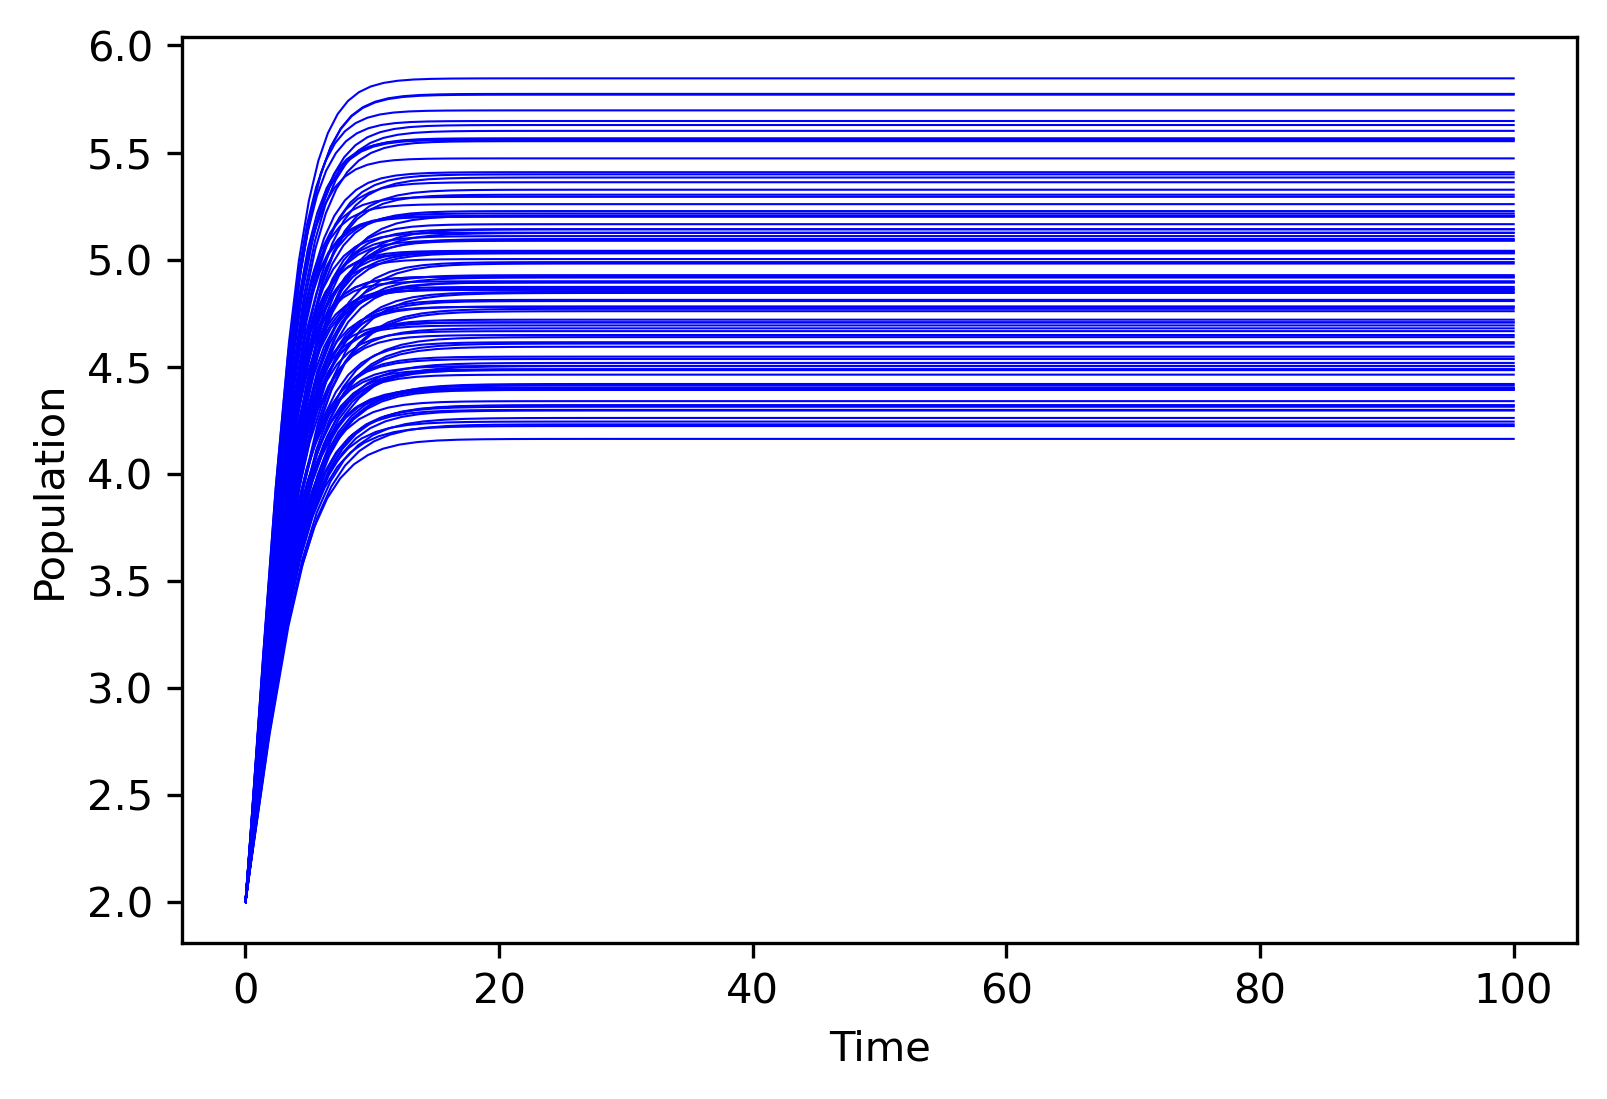

In [64]:
import scipy.integrate

h = 0.5 # constant harvesting rate
tmin = 0
tmax = 100
n_samples = 100
P_ss_array = np.zeros(n_samples)
r_array = rng.uniform(0.9, 1.1, n_samples)
K_array = rng.uniform(9.0, 11.0, n_samples)

# modify function to accept r,K parameter inputs. h is constant.
def dydt(t,P,r,K):
    return r * P * (1 - P / K) - h * P

for i in range(n_samples):

    # additional args r,K passed from solve_ivp to dydt 
    sol = scipy.integrate.solve_ivp(dydt, 
                                    t_span=[tmin, tmax], 
                                    y0=[2],
                                    rtol=1e-6,
                                    args=(r_array[i], K_array[i]))
    P_ss_array[i] = sol.y[0,-1] # last value estimate of steady state

    plt.plot(sol.t, sol.y[0,:], c='blue', lw=0.5)

plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

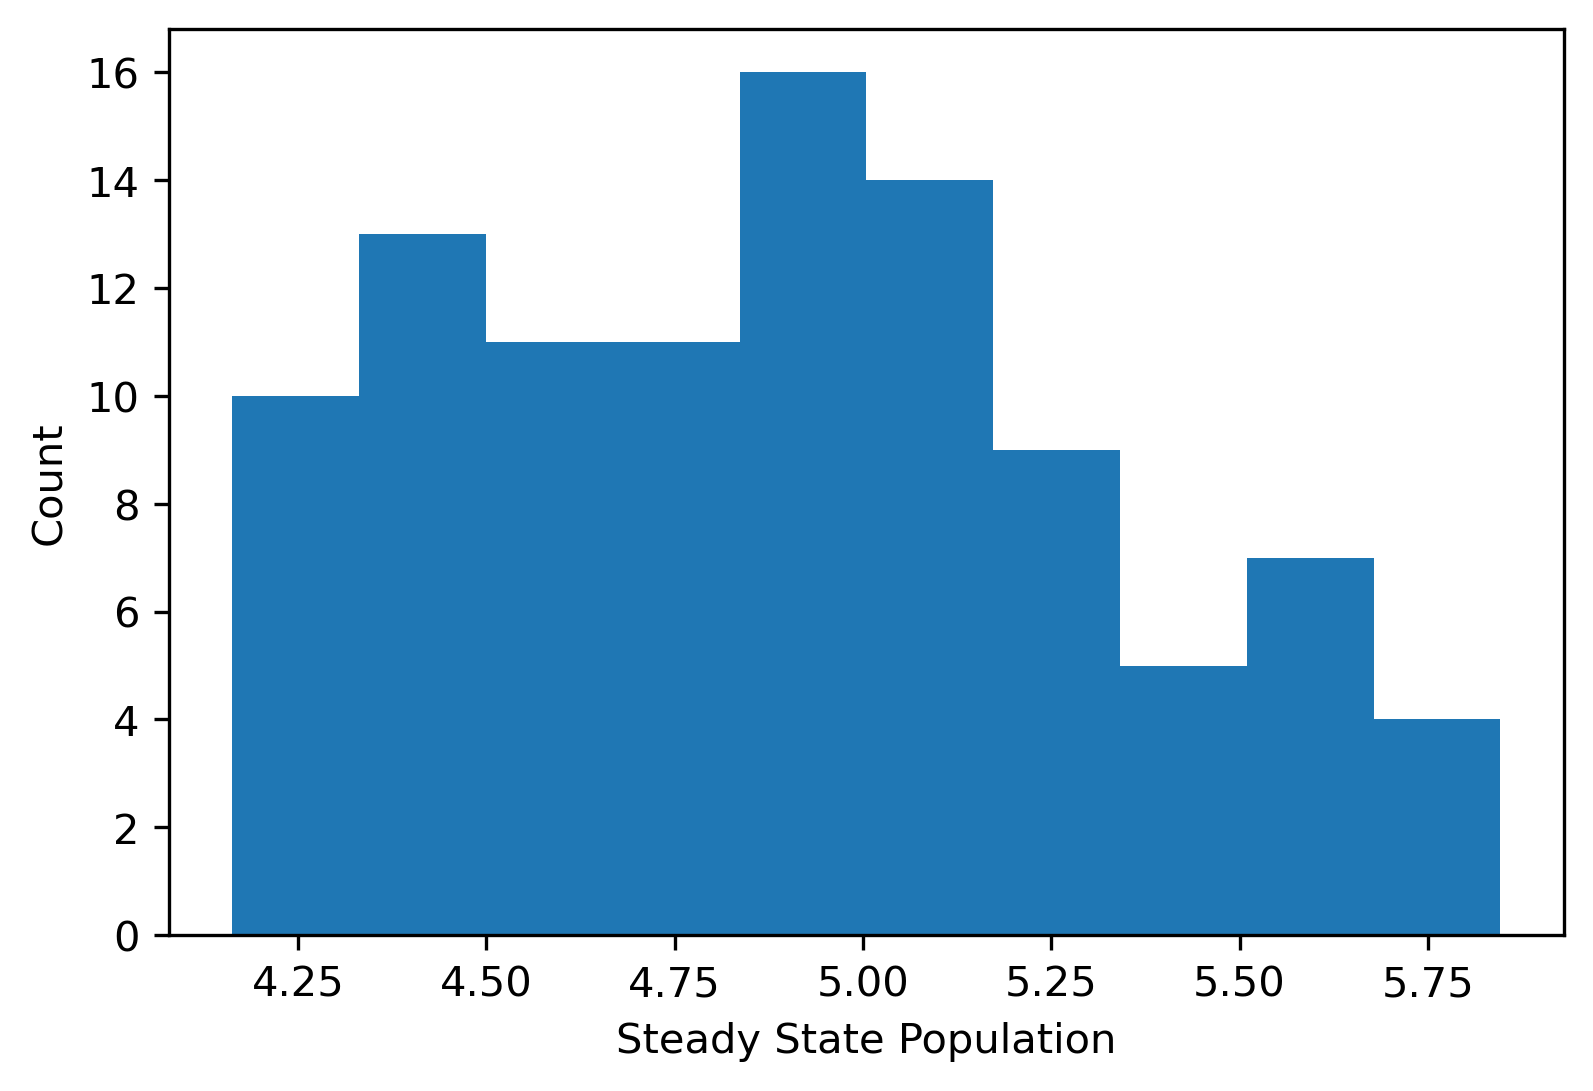

In [65]:
plt.hist(P_ss_array)
plt.xlabel('Steady State Population')
plt.ylabel('Count')
plt.show()

The output does not look normally distributed with 100 samples. To report the uncertainty, we can use the percentiles of the distribution.

In [68]:
print('Mean: ', P_ss_array.mean())
print('2.5th pctile: ', np.quantile(P_ss_array, 0.025))
print('97.5th pctile: ', np.quantile(P_ss_array, 0.975))  

Mean:  4.890199847092392
2.5th pctile:  4.236732662944297
97.5th pctile:  5.735276276207013


What happens to the histogram if $r$ is uniformly distributed on $[0.4, 1.1]$ ? Why?